In [2]:
%matplotlib nbagg
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit

In [3]:
DIR = "/sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/"
#DIR = "/sf/alvra/data/p17589/raw/"

!ls -lah -t /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/
#!ls -lah -t /sf/alvra/data/p17589/raw/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 226M
drwxrwsr-x. 124 39147 p17569  32K Dec 19 16:57 ..
drwxrwsr-x.   2 root  p17569 4.0K Dec 10 21:47 .
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:47 Laser_knife_edge_X_004_step0040.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:47 Laser_knife_edge_X_004_step0039.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:47 Laser_knife_edge_X_004_step0038.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:47 Laser_knife_edge_X_004_step0037.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:47 Laser_knife_edge_X_004_step0036.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:46 Laser_knife_edge_X_004_step0035.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:46 Laser_knife_edge_X_004_step0034.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:46 Laser_knife_edge_X_004_step0033.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:46 Laser_knife_edge_X_004_step0032.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:46 Laser_knife_edge_X_004_step0031.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:46 Laser_knife_edge_X_004_

In [4]:
channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_position = "SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position

In [5]:
fileName = "Laser_knife_edge_X_015_step0000.h5"

BS_file = h5py.File(DIR + fileName)
#print(list(BS_file["data"].keys()))

#PIPS_trans = BS_file[channel_PIPS_trans]  
LaserDiode = BS_file[channel_LaserDiode]
LaserIzero = BS_file[channel_Laser_refDiode]
pulse_ids = BS_file[channel_pulse_ids]    

In [6]:
print (pulse_ids[0])

7314682000


<IPython.core.display.Javascript object>


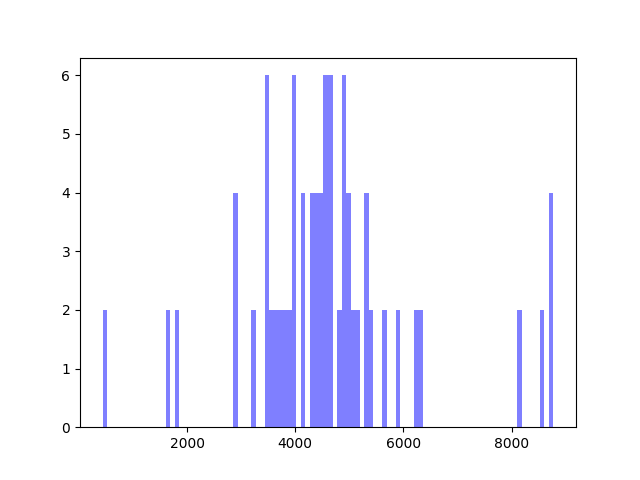

In [37]:
num_bins = 100
plt.figure()
plt.hist(LaserIzero[:], num_bins, facecolor='blue', alpha=0.5)
#plt.hist(LaserDiode[:], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [49]:
print(pulse_ids.size)

100


In [5]:
### this is now to loop over SEVERAL FILES

fileName_root = 'Laser_knife_edge_X_004'
Int_threshold = 5

listfile = os.listdir(DIR)
number_files = int(len(listfile))
#number_files = 80

print ("Start processing",number_files,"files")


Position = []
signal = []
err_signal = []

Izero = []
err_Izero = []

for j in range(number_files):
    
    
    n_ok = 0
    n_empty = 0
    
    data_loop = []
    Izero_loop =[]
    
    if j < 10:
        fileName_bs = fileName_root + "_step000" + str(j) + ".h5"
    else:
        fileName_bs = fileName_root + "_step00" + str(j) + ".h5"
    bs_file = h5py.File(DIR + fileName_bs, 'r')
    
    Position.append(bs_file[channel_position][0])
    pulse_ids = bs_file[channel_pulse_ids]
    
    print("step",j+1,"of",number_files,": Processing %s" % (fileName_bs))
    
    nframes = pulse_ids.size
    
    for i in range(nframes):  
        data = bs_file[channel_LaserDiode][i]
        data_Izero = bs_file[channel_Laser_refDiode][i] 
        if pulse_ids[i] != 0:
            
            data_loop.append(data)
            Izero_loop.append(data_Izero)
            n_ok += 1
        
        else:
        
            n_empty += 1
        
    print ('Total shots =',nframes,', Empty shots =',n_empty,', Good shots =',n_ok,)
        
    data_loop = np.array(data_loop)
    Izero_loop = np.array(Izero_loop)
   
    signal.append(data_loop.mean())
    err_signal.append(data_loop.std() / np.sqrt(n_ok))
    Izero.append(Izero_loop.mean())
    err_Izero.append(Izero_loop.std() / np.sqrt(n_ok))

signal = np.array(signal)
err_signal = np.array(err_signal)
Izero = np.array(Izero)
err_Izero = np.array(err_Izero)
    
print ("Job done!")

Start processing 41 files
step 1 of 41 : Processing Laser_knife_edge_X_004_step0000.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 2 of 41 : Processing Laser_knife_edge_X_004_step0001.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 3 of 41 : Processing Laser_knife_edge_X_004_step0002.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 4 of 41 : Processing Laser_knife_edge_X_004_step0003.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 5 of 41 : Processing Laser_knife_edge_X_004_step0004.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 6 of 41 : Processing Laser_knife_edge_X_004_step0005.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 7 of 41 : Processing Laser_knife_edge_X_004_step0006.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 8 of 41 : Processing Laser_knife_edge_X_004_step0007.h5
Total shots = 100 , Empty shots = 0 , Good shots = 100
step 9 of 41 : Processing Laser_knife_edge_X_0

In [10]:
Izero_loop

array([124.59259259, 124.59259259, 146.56790123, 146.56790123,
       144.64197531, 144.64197531, 139.24691358, 139.24691358,
       134.13580247, 134.13580247, 149.58024691, 149.58024691,
       162.60493827, 162.60493827, 139.38271605, 139.38271605,
       143.49382716, 143.49382716, 139.64197531, 139.64197531,
       139.44444444, 139.44444444, 139.24691358, 139.24691358,
       144.55555556, 144.55555556, 165.51851852, 165.51851852,
       166.30864198, 166.30864198, 149.27160494, 149.27160494,
       154.08641975, 154.08641975, 118.80246914, 118.80246914,
       130.4691358 , 130.4691358 , 132.71604938, 132.71604938,
       186.51851852, 186.51851852, 150.50617284, 150.50617284,
       176.12345679, 176.12345679, 137.39506173, 137.39506173,
       137.95061728, 137.95061728, 125.56790123, 125.56790123,
       167.41975309, 167.41975309, 116.07407407, 116.07407407,
       144.71604938, 144.71604938, 154.79012346, 154.79012346,
       129.35802469, 129.35802469, 107.41975309, 107.41

In [6]:
#position_manual = np.arange(12.6,13.120,0.020)
signal_norm = signal / Izero
err_signal_norm = err_signal / Izero

<IPython.core.display.Javascript object>


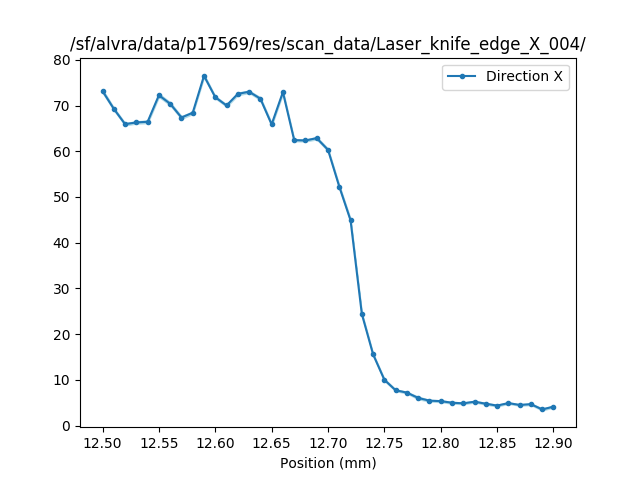

In [7]:
plt.figure()

plt.plot(Position, signal_norm, label="Direction X",marker='.')

low_err= signal_norm - err_signal_norm
high_err= signal_norm + err_signal_norm

plt.fill_between(Position, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig('Timescan_7_diode')

In [9]:
def errfunc(x, a, b, c, d):
    #This used at the beginning, probably wrong
    #return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))
    
    #This is from http://people.fjfi.cvut.cz/blazejos/public/ul7en.pdf Eq. 4, the parameter d returns the 1/e2 value (w)
    #return a + b*erf(np.sqrt(np.log(2))*(c-x)/(np.abs(d)))             
    
    #This is the same as before with in addition w = sqrt(2 ln2)/FWHM, so now parameter d returns the FWHM, so I think
    #it is the correct one.
    return a + b*erf((np.sqrt(2))*(c-x)/(np.abs(d/np.sqrt(2*np.log(2)))))
        

In [19]:
parameters,extras = curve_fit(errfunc, Position, signal_norm, p0 = [70, 0.1, 12.7, 0.05])

In [20]:
parameters

array([ 0.78913333, -0.0708624 , 12.87406343,  0.02009867])

<IPython.core.display.Javascript object>


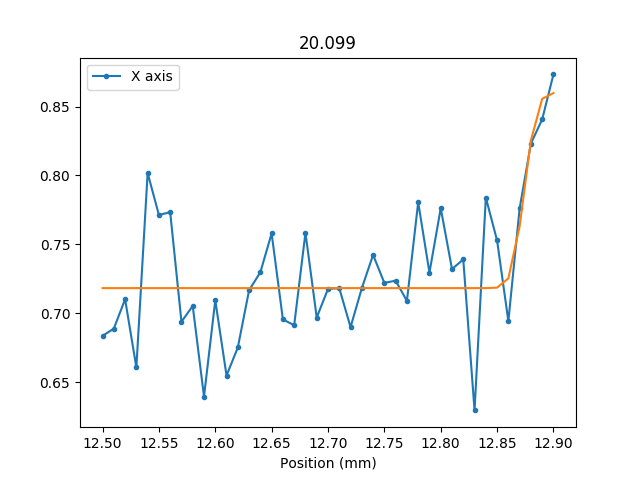

In [21]:
plt.figure()

plt.plot(Position, signal_norm, label="X axis",marker='.')
plt.plot(Position, errfunc(Position,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(position, low_err, high_err, color='lightblue')
plt.title(np.abs(np.round(parameters[3]*1000, 3)))
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig('Timescan_7_diode')

<IPython.core.display.Javascript object>


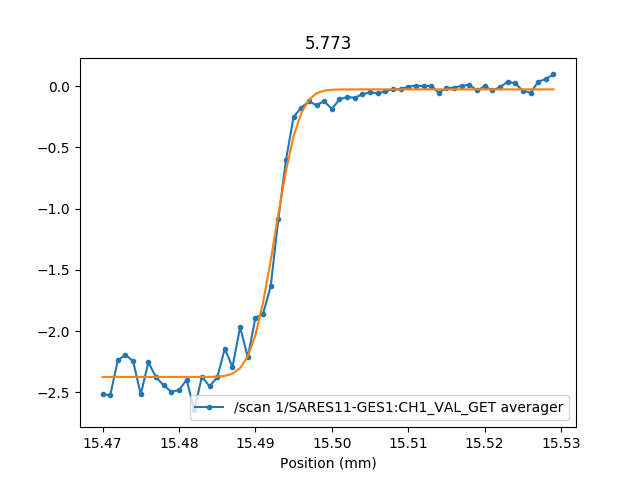

In [17]:
##This cell uses as test for the fit with the errfit function

nametest = "/sf/alvra/config/pshell_data/2018_11/20181129/20181129_140140_knife_edge_scan_X.h5"
testfile = h5py.File(nametest)
xdata = testfile["scan 1/SARES11-XSAM125:MOTOR_Y1.VAL"]
signal = testfile["scan 1/SARES11-GES1:CH1_VAL_GET averager"]

parameters,extras = curve_fit(errfunc,xdata,signal, p0 = [0, -2, 15.49, 0.01])

plt.figure()

plt.plot(xdata, signal, marker='.')
plt.plot(xdata, errfunc(xdata,*parameters))
plt.title(np.round(parameters[3]*1000, 3) )
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()